# Training a Sample GP Model

Training a GP model to predict molar mass from the HF/def2-SVP-YK sigma profiles. Make sure to install and activate the `gpflow-env` conda environment before running this notebook.

## 1. Imports

In [35]:
# General
import os
import warnings
import time
import sys

# Specific
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import preprocessing
import gpflow
from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from matplotlib import rc
from tqdm import tqdm
import pickle


In [36]:
# Plot configuraiton
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
plt.rcParams["font.family"] = "Serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
rc('axes', labelsize='16')
rc('xtick', labelsize='14')
rc('ytick', labelsize='14')
rc('legend', fontsize='12')
mpl.rcParams['lines.linewidth'] = 2
plt.rcParams["savefig.pad_inches"]=0.02

## 2. Configuration

### 2.1. Select GP Settings and SP Dataset

In [37]:
# Define normalization methods
featureNorm = None              # None,Standardization,MinMax,LogStand,Log+bStand
labelNorm = 'Standardization'   # None,Standardization,MinMax,LogStand,Log+bStand

# GP Configuration
gpConfig = {'kernel':'RBF',
            'useWhiteKernel':True,
            'trainLikelihood':True,
            'alpha':10**-2}

# list datasets for training and plotting
dataset = 'sp_hf_def2-svp_yk'
dataset_name = 'HF/def2-SVP-YK (No Avg.)'

# define dataset folders
dataset_folder = '..'

# define problematic molecules to remove from all datasets
prob_mols = [690]


### 2.2. Select Target Property to Model

In [38]:
# Get target variable/property name, dataset codes, and display units
varNames=['Molar Mass', 'Boiling Point', 'Density at 20°C', 'RI at 20°C', '$S_{aq}$ at 25°C (g/kg)', 'Vapor Pressure']
codes = ['MM', 'BP', 'D_20', 'RI_20', 'S_25', 'VP']
varUnits=['g/mol', '°C', 'g/cm³', 'RI', 'g/kg', 'Pa']

# Select index of property to train on
v = 0 # Molar mass

# Extract variable to be trained on
varName = varNames[v]
code = codes[v]
varUnit = varUnits[v]

# Change normalization method for solubility and vapor pressure
if code in ['S_25', 'VP']:
    labelNorm='LogStand'

print(f'Fitting GP to {varName}')

# Select k-fold or data split
k = 0

Fitting GP to Molar Mass


## 3. Functions

In [39]:
def normalize(inputArray,skScaler=None,method='Standardization',reverse=False):
    """
    normalize() normalizes (or unnormalizes) inputArray using the method
    specified and the skScaler provided.

    Parameters
    ----------
    inputArray : np array
        Array to be normalized. If dim>1, array is normalized column-wise.
    skScaler : scikit-learn preprocessing object or None
        Scikit-learn preprocessing object previosly fitted to data. If None,
        the object is fitted to inputArray.
        Default: None
    method : string, optional
        Normalization method to be used.
        Methods available:
            . Standardization - classic standardization, (x-mean(x))/std(x)
            . MinMax - scale to range (0,1)
            . LogStand - standardization on the log of the variable,
                         (log(x)-mean(log(x)))/std(log(x))
            . Log+bStand - standardization on the log of variables that can be
                           zero; uses a small buffer,
                           (log(x+b)-mean(log(x+b)))/std(log(x+b))
        Defalt: 'Standardization'
    reverse : bool
        Whether  to normalize (False) or unnormalize (True) inputArray.
        Defalt: False

    Returns
    -------
    inputArray : np array
        Normalized (or unnormalized) version of inputArray.
    skScaler : scikit-learn preprocessing object
        Scikit-learn preprocessing object fitted to inputArray. It is the same
        as the inputted skScaler, if it was provided.

    """
    # If inputArray is a labels vector of size (N,), reshape to (N,1)
    if inputArray.ndim==1:
        inputArray=inputArray.reshape((-1,1))
        warnings.warn('Input to normalize() was of shape (N,). It was assumed'\
                      +' to be a column array and converted to a (N,1) shape.')
    # If skScaler is None, train for the first time
    if skScaler is None:
        # Check method
        if method=='Standardization' or method=='MinMax': aux=inputArray
        elif method=='LogStand': aux=np.log(inputArray)
        elif method=='Log+bStand': aux=np.log(inputArray+10**-3)
        else: raise ValueError('Could not recognize method in normalize().')
        if method!='MinMax':
            skScaler=preprocessing.StandardScaler().fit(aux)
        else:
            skScaler=preprocessing.MinMaxScaler().fit(aux)
    # Do main operation (normalize or unnormalize)
    if reverse:
        # Rescale the data back to its original distribution
        inputArray=skScaler.inverse_transform(inputArray)
        # Check method
        if method=='LogStand': inputArray=np.exp(inputArray)
        elif method=='Log+bStand': inputArray=np.exp(inputArray)-10**-3
    elif not reverse:
        # Check method
        if method=='Standardization' or method=='MinMax': aux=inputArray
        elif method=='LogStand': aux=np.log(inputArray)
        elif method=='Log+bStand': aux=np.log(inputArray+10**-3)
        else: raise ValueError('Could not recognize method in normalize().')
        inputArray=skScaler.transform(aux)
    # Return
    return inputArray,skScaler

In [40]:
def buildGP(X_Train,Y_Train,gpConfig={}):
    """
    buildGP() builds and fits a GP model using the training data provided.

    Parameters
    ----------
    X_Train : np array (N,K)
        Training features, where N is the number of data points and K is the
        number of independent features (e.g., sigma profile bins).
    Y_Train : np array (N,1)
        Training labels (e.g., property of a given molecule).
    gpConfig : dictionary, optional
        Dictionary containing the configuration of the GP. If a key is not
        present in the dictionary, its default value is used.
        Keys:
            . kernel : string
                Kernel to be used. One of:
                    . 'RBF' - gpflow.kernels.RBF()
                    . 'RQ' - gpflow.kernels.RationalQuadratic()
                    . 'Matern32' - gpflow.kernels.Matern32()
                    . 'Matern52' - gpflow.kernels.Matern52()
                The default is 'RQ'.
            . useWhiteKernel : boolean
                Whether to use a White kernel (gpflow.kernels.White).
                The default is True.
            . trainLikelihood : boolean
                Whether to treat the variance of the likelihood of the modeal
                as a trainable (or fitting) parameter. If False, this value is
                fixed at 10^-5.
                The default is True.
            . alpha : float
                Initial value for the noise variance of the model.
        The default is {}.
    Raises
    ------
    UserWarning
        Warning raised if the optimization (fitting) fails to converge.

    Returns
    -------
    model : gpflow.models.gpr.GPR object
        GP model.

    """
    # Unpack gpConfig
    kernel=gpConfig.get('kernel','RQ')
    useWhiteKernel=gpConfig.get('useWhiteKernel','True')
    trainLikelihood=gpConfig.get('trainLikelihood','True')
    alpha=gpConfig.get('alpha',10**-2)
    # Select and initialize kernel
    if kernel=='RBF':
        gpKernel=gpflow.kernels.SquaredExponential()
    if kernel=='RQ':
        gpKernel=gpflow.kernels.RationalQuadratic()
    if kernel=='Matern32':
        gpKernel=gpflow.kernels.Matern32()
    if kernel=='Matern52':
        gpKernel=gpflow.kernels.Matern52()
    # Add White kernel
    if useWhiteKernel: gpKernel=gpKernel+gpflow.kernels.White()
    # Build GP model    
    model=gpflow.models.GPR((X_Train,Y_Train),gpKernel,noise_variance=alpha)
    # Select whether the likelihood variance is trained
    gpflow.utilities.set_trainable(model.likelihood.variance,trainLikelihood)
    # Build optimizer
    optimizer=gpflow.optimizers.Scipy()
    # Fit GP to training data
    aux=optimizer.minimize(model.training_loss,
                           model.trainable_variables,
                        #    method='L-BFGS-B')
                           method='BFGS')
    # Check convergence
    if aux.success==False:
        warnings.warn('GP optimizer failed to converge.')
    # Output
    return model

In [41]:
def gpPredict(model,X):
    """
    gpPredict() returns the prediction and standard deviation of the GP model
    on the X data provided.

    Parameters
    ----------
    model : gpflow.models.gpr.GPR object
        GP model.
    X : np array (N,K)
        Training features, where N is the number of data points and K is the
        number of independent features (e.g., sigma profile bins).

    Returns
    -------
    Y : np array (N,1)
        GP predictions.
    STD : np array (N,1)
        GP standard deviations.

    """
    # Do GP prediction, obtaining mean and variance
    GP_Mean,GP_Var=model.predict_f(X)
    # Convert to np
    GP_Mean=GP_Mean.numpy()
    GP_Var=GP_Var.numpy()
    # Prepare outputs
    Y=GP_Mean
    STD=np.sqrt(GP_Var)
    # Output
    return Y,STD

In [42]:
def find_zero_cols(property_name, sp_dataset, LOUD=False):
    '''Read the SPs and property data from a specified dataset and return the all-zero columns
    Args:
        property_name: str, name of the property to be predicted
        sp_dataset: str, name of the dataset containing the sigma profiles
    Returns:
        zero_col: np.array, column indices
    '''
    # read generated sigma profiles
    sp_gen = pd.read_csv(f'{dataset_folder}/{sp_dataset}.csv', index_col=0)

    # remove molecules with large sigma ranges
    for prob_idx in prob_mols:
        sp_gen = sp_gen.drop(index=prob_idx)

    # get all valid indices where sp_gen is not nan (x_data)
    valid_x_idx = sp_gen.index[~sp_gen.isna().any(axis=1)]

    # remove columns 1 and 2 and save them to variables
    mol_cas = sp_gen['CAS Number']
    mol_names = sp_gen['Name']
    sp_gen = sp_gen.drop(columns=['CAS Number', 'Name']) # remove columns

    # read target property
    prop = pd.read_csv(f'k-fold-Target-Databases/{property_name}_mlDatabase_Original.csv', index_col=0)
    try:
        prop = prop.drop(columns=['CAS Number', 'Name', 'Temperature /ºC']) # remove columns
    except:
        prop = prop.drop(columns=['CAS Number', 'Name'])
    prop = prop.iloc[:, 0]

    # get common indices between x and y
    y_idx = prop.index
    valid_idx = np.intersect1d(valid_x_idx, y_idx)

    # get x and y data for valid indices
    x_data = sp_gen.loc[valid_idx].to_numpy()
    y_data = prop.loc[valid_idx].to_numpy().reshape(-1, 1)

    # Remove comment columns from SPs, if any
    if type(x_data[1,-1]) == str:
        # remove comment columns
        x_data = x_data[:,:-1].astype(float)

    # find all-zero columns in x-data
    zero_col = np.where(~x_data.any(axis=0))[0]

    # if no all-zero columns are found, return an empy list
    if len(zero_col) == 0:
        return []
        
    # get only zero columns at the edges of the sigma profile
    z_1 = zero_col[0]
    z_2 = zero_col[-1]
    for z in zero_col:
        # compare z with z1
        if np.abs(z-z_1) <= 1:
            z_1 = z
    for z in reversed(zero_col):
        # compare z with z2
        if np.abs(z-z_2) <= 1:
            z_2 = z
    
    # update zero_col to remove columns between z1 and z2
    zero_col = zero_col[np.where((zero_col <= z_1) | (zero_col >= z_2))]

    if LOUD:
        print(f'Number of all-zero columns in {property_name} dataset {sp_dataset}: {len(zero_col)}')

    return zero_col

In [43]:
def extract_data(kfold, property_name, sp_dataset, training=True, return_valid_idx=False, valid_idx=None, return_metadata=False):
    '''Read the SPs and prpoerty data from a specified dataset and return the training and testing data
    Args:
        kfold: int, kfold number
        property_name: str, name of the property to be predicted
        sp_dataset: str, name of the dataset containing the sigma profiles
        training: bool, if True, read the training property data, else read the testing property data
        return_valid_idx: bool, if True, return the valid indices
        valid_idx: np.array, valid indices
        return_metadata: bool, if true, meta data (sigma or charge density, names and CAS numbers) is returned
    Returns:
        x_data: np.array, sigma profiles
        y_data: np.array, target property
        valid_idx: np.array, valid indices (optional)
    '''
    # read generated sigma profiles
    sp_gen = pd.read_csv(f'{dataset_folder}/{sp_dataset}.csv', index_col=0)

    # remove molecules with large sigma ranges
    for prob_idx in prob_mols:
        sp_gen = sp_gen.drop(index=prob_idx)

    # get all valid indices where sp_gen is not nan (x_data)
    valid_x_idx = sp_gen.index[~sp_gen.isna().any(axis=1)]

    # remove columns 1 and 2 and save them to variables if any
    try:
        mol_cas = sp_gen['CAS Number']
        mol_names = sp_gen['Name']
        sp_gen = sp_gen.drop(columns=['CAS Number', 'Name']) # remove columns
    except:
        pass

    # get sigma values
    sigma = sp_gen.columns.to_numpy().astype(float)
    
    # read target property
    dataset_name = f'_TrainSet_{kfold}' if training else f'_TestSet_{kfold}'
    prop = pd.read_csv(f'k-fold-Target-Databases/{property_name}_mlDatabase{dataset_name}.csv', index_col=0)
    try:
        prop = prop.drop(columns=['CAS Number', 'Name']) # remove columns
    except:
        pass
    prop = prop.iloc[:, 0]

    # get common indices between x and y
    if valid_idx is None:
        y_idx = prop.index
        valid_idx = np.intersect1d(valid_x_idx, y_idx)
    else:
        valid_idx = valid_idx

    # get x and y data for valid indices
    x_data = sp_gen.loc[valid_idx].to_numpy()
    y_data = prop.loc[valid_idx].to_numpy().reshape(-1, 1)

    # Remove comment columns from SPs, if any
    if type(x_data[1,-1]) == str:
        # remove comment columns
        x_data = x_data[:,:-1].astype(float)

    # get columns that are all zeros
    zero_col = find_zero_cols(property_name, sp_dataset, LOUD=False)
    
    # remove columns that are all zeros from x_data and sigma
    x_data = np.delete(x_data, zero_col, axis=1)
    sigma = np.delete(sigma, zero_col)

    # convert sigma to floats and round if necessary
    sigma = np.round(sigma, 3)

    if return_valid_idx == True and return_metadata == False:
        return x_data, y_data, valid_idx
    elif return_valid_idx == True and return_metadata == True:
        return x_data, y_data, valid_idx, (sigma, mol_names, mol_cas)
    elif return_valid_idx == False and return_metadata == True:
        return x_data, y_data, (sigma, mol_names, mol_cas)
    else:
        return x_data, y_data

## 4. Train GP

### 4.1. Extract Data

In [44]:
# Extract training and testing data
X_Train, Y_Train, valid_idx_train, metadata = extract_data(k, code, dataset, training=True, return_valid_idx=True, return_metadata=True)
X_Test, Y_Test, valid_idx_test = extract_data(k, code, dataset, training=False, return_valid_idx=True)

sigma, names, cas_numbers = metadata

# Normalize features
if featureNorm is not None:
    X_Train_N,skScaler_X_Train=normalize(X_Train,method=featureNorm)
    X_Test_N,__=normalize(X_Test,skScaler=skScaler_X_Train,
                        method=featureNorm)
else:
    X_Train_N=X_Train
    X_Test_N=X_Test

# Normalize targets
if labelNorm is not None:
    Y_Train_N,skScaler_Y_Train=normalize(Y_Train,method=labelNorm)
else:
    Y_Train_N=Y_Train

# Print dataset shapes
print(f"Training dataset shapes:\n \tInput data: {X_Train.shape}\n\tTarget data: {Y_Train.shape}")
print(f"Testing dataset shapes:\n \tInput data: {X_Test.shape}\n\tTarget data: {Y_Test.shape}")

# Print select metadata
print(f"\nSigma range: ({sigma.min():.3f}, {sigma.max():.3f}) ē/Å²")

Training dataset shapes:
 	Input data: (1284, 469)
	Target data: (1284, 1)
Testing dataset shapes:
 	Input data: (143, 469)
	Target data: (143, 1)

Sigma range: (-0.160, 0.308) ē/Å²


### 4.2. Visualize Data Distributions

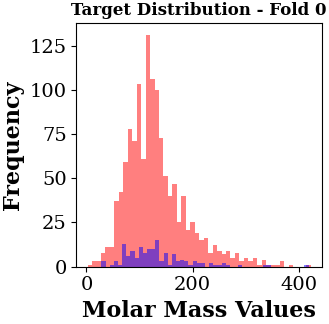

In [45]:
# Initialize figure
n_rows = 1; n_cols = 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*3.5))

# Plot histograms
ax.hist(Y_Train, bins=50, color='red', alpha=0.5, label = f'Training set')
ax.hist(Y_Test, bins=50, color='blue', alpha=0.5, label = f'Testing set')
ax.set_xlabel(f'{varName} Values', weight='bold')
ax.set_ylabel(f'Frequency', weight='bold')
ax.set_title(f'Target Distribution - Fold {k}', weight='bold')
plt.tight_layout()
plt.show()

### 4.3. Visualize Data Samples

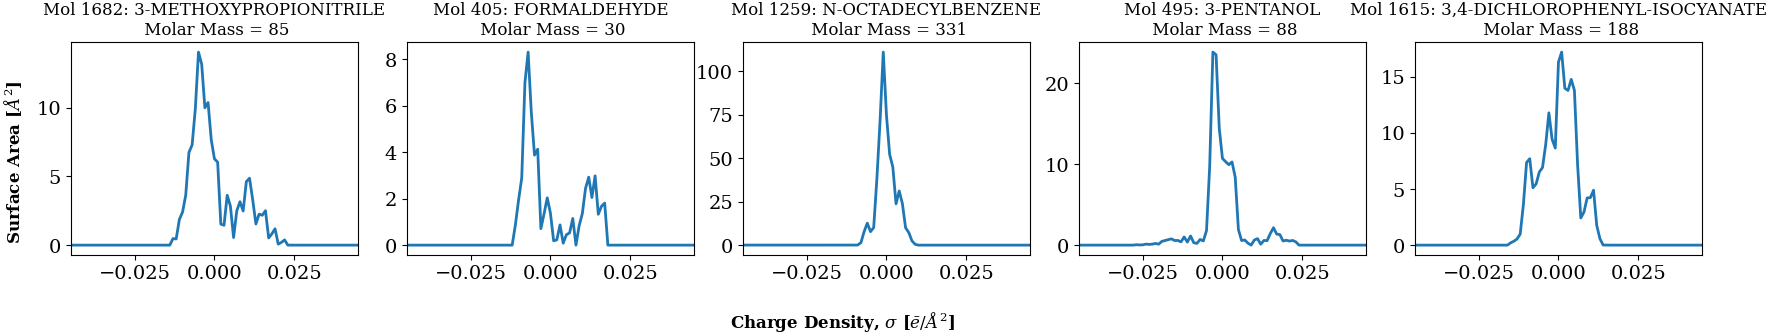

In [46]:
# Number of samples to visualize
n_samples = 5

# Randomly select samples
np.random.seed(42)
sample_indices = np.random.choice(X_Train.shape[0], n_samples, replace=False)

# Create a new figure for the samples
n_rows = 1; n_cols = n_samples
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*3.5))

# Plot each sample
for i, idx in enumerate(sample_indices):
    # Get the sample data
    x_sample = X_Train[idx]
    y_sample = Y_Train[idx]
    database_idx = valid_idx_train[idx]
    
    # Plot the sample
    ax[i].plot(sigma, x_sample)
    ax[i].set_title(f'Mol {database_idx}: {names[database_idx]}\n {varName} = {y_sample[0]:.0f}')
    ax[i].set_xlim([-0.045, 0.045])

fig.supylabel(r'Surface Area [$\AA^2$]', weight='bold')
fig.supxlabel(r'Charge Density, $\sigma$ [$\bar{e}/\AA^2$]', weight='bold')
fig.tight_layout(w_pad=0.15,  rect=(0.01,0,1,1))


### 4.3. Train GP Model

In [47]:
# Train GP
model=buildGP(X_Train_N,Y_Train_N,gpConfig=gpConfig)

In [48]:
# Print model summary
gpflow.utilities.print_summary(model) 

╒════════════════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤══════════════╕
│ name                               │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │        value │
╞════════════════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪══════════════╡
│ GPR.kernel.kernels[0].variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │  2.26876     │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[0].lengthscales │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 37.7         │
├────────────────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼──────────────┤
│ GPR.kernel.kernels[1].variance     │ Parameter │ Softplus         │         │ True        │ () 

In [49]:
# Get GP predictions
Y_Train_Pred_N,STD_Train=gpPredict(model,X_Train_N)
Y_Test_Pred_N,STD_Test=gpPredict(model,X_Test_N)

# Denormalize
if labelNorm is not None:
    Y_Train_Pred,__=normalize(Y_Train_Pred_N,skScaler=skScaler_Y_Train,
                            method=labelNorm,reverse=True)
    Y_Test_Pred,__=normalize(Y_Test_Pred_N,skScaler=skScaler_Y_Train,
                            method=labelNorm,reverse=True)
else:
    Y_Train_Pred=Y_Train_Pred_N
    Y_Test_Pred=Y_Test_Pred_N

In [50]:
# Calculate metrics
if code=='VP' or code=='S_25':
    # Get logs of y_data
    log_Y_Train_Pred=np.log(Y_Train_Pred)
    log_Y_Test_Pred=np.log(Y_Test_Pred)

    # Remove Nan values if any
    log_Y_Train=np.log(Y_Train[~np.isnan(log_Y_Train_Pred)])
    log_Y_Test=np.log(Y_Test[~np.isnan(log_Y_Test_Pred)])
    log_Y_Train_Pred=log_Y_Train_Pred[~np.isnan(log_Y_Train_Pred)]
    log_Y_Test_Pred=log_Y_Test_Pred[~np.isnan(log_Y_Test_Pred)]

    # Compute metrics
    R2_Train=metrics.r2_score(log_Y_Train,log_Y_Train_Pred)
    R2_Test=metrics.r2_score(log_Y_Test,log_Y_Test_Pred)
    MAE_Train=metrics.mean_absolute_error(Y_Train,Y_Train_Pred)
    MAE_Test=metrics.mean_absolute_error(Y_Test,Y_Test_Pred)

else:
    # Remove Nan values if any
    Y_Train=Y_Train[~np.isnan(Y_Train_Pred)]
    Y_Test=Y_Test[~np.isnan(Y_Test_Pred)]
    Y_Train_Pred=Y_Train_Pred[~np.isnan(Y_Train_Pred)]
    Y_Test_Pred=Y_Test_Pred[~np.isnan(Y_Test_Pred)]

    # Compute metrics
    R2_Train=metrics.r2_score(Y_Train,Y_Train_Pred)
    R2_Test=metrics.r2_score(Y_Test,Y_Test_Pred)
    MAE_Train=metrics.mean_absolute_error(Y_Train,Y_Train_Pred)
    MAE_Test=metrics.mean_absolute_error(Y_Test,Y_Test_Pred)

## 5. Plot GP Predictions

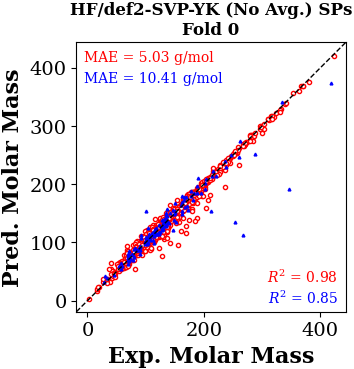

In [51]:
# Initialize subplot figure for property v
n_rows = 1;    n_cols = 1
fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols*3.5, n_rows*3.5))

# Scatter Predictions
if code=='VP' or code=='S_25':
    ax.loglog(Y_Train,Y_Train_Pred,'ow',markersize=3,mec='red')
    ax.loglog(Y_Test,Y_Test_Pred,'^b',markersize=2)
else:
    ax.plot(Y_Train,Y_Train_Pred,'ow',markersize=3,mec='red')
    ax.plot(Y_Test,Y_Test_Pred,'^b',markersize=2)

# Plot 1:1 line
lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
ax.axline((lims[0], lims[0]), (lims[1], lims[1]), color='k', linestyle='--', linewidth=1)
ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel(f'Exp. {varName}', weight='bold')
ax.set_ylabel(f'Pred. {varName}', weight='bold')
ax.set_title(f'{dataset_name} SPs\nFold {k}', weight='bold')
ax.set_aspect('equal', adjustable='box')

ax.text(0.03,0.93,
        'MAE = '+'{:.2f} '.format(MAE_Train)+varUnit,
        horizontalalignment='left',
        transform=ax.transAxes,c='r')
ax.text(0.03,0.85,
        'MAE = '+'{:.2f} '.format(MAE_Test)+varUnit,
        horizontalalignment='left',
        transform=ax.transAxes,c='b')
ax.text(0.97,0.11,'$R^2$ = '+'{:.2f}'.format(R2_Train),
        horizontalalignment='right',
        transform=ax.transAxes,c='r')
ax.text(0.97,0.03,'$R^2$ = '+'{:.2f}'.format(R2_Test),
        horizontalalignment='right',
        transform=ax.transAxes,c='b')

# plt.tight_layout(rect=(0.1,0.1,1.1,1.1))
plt.show()
